In [2]:
import tensorflow as tf
from tensorflow.keras import layers, models
import tensorflow_hub as hub
import numpy as np
import librosa
import os


In [3]:
yamnet_model_handle = "https://tfhub.dev/google/yamnet/1"
yamnet_layer = hub.KerasLayer(yamnet_model_handle, trainable=False, name='yamnet')

In [14]:
def load_audio_from_directory(directory_path, num_files=None, max_len=16000):
    audio_files = []
    for filename in os.listdir(directory_path)[:num_files]:
        if filename.endswith('.wav'):
            file_path = os.path.join(directory_path, filename)
            waveform, sr = librosa.load(file_path, sr=16000)

            # Uzunluğu sabitle (padding veya truncate)
            if len(waveform) < max_len:
                waveform = np.pad(waveform, (0, max_len - len(waveform)), mode='constant')
            else:
                waveform = waveform[:max_len]

            audio_files.append(waveform)
    return audio_files






In [28]:
how_many = 1000

sick_audio_files = load_audio_from_directory('data/data/Sick', how_many)
healthy_audio_files = load_audio_from_directory('data/data/Healthy', how_many)
none_audio_files = load_audio_from_directory('data/data/None', how_many)

In [29]:
import numpy as np

# Etiketler: Sick → 1, Healthy → 0, None → 2
X = np.array(sick_audio_files + healthy_audio_files + none_audio_files, dtype=np.float32)
y = np.array(
    [1] * len(sick_audio_files) + 
    [0] * len(healthy_audio_files) + 
    [2] * len(none_audio_files), 
    dtype=np.int32
)

print("X shape:", X.shape)  # (örnek_sayısı, örnek_uzunluğu)
print("y shape:", y.shape)  # (örnek_sayısı,)


X shape: (3000, 16000)
y shape: (3000,)


In [ ]:
from sklearn.model_selection import train_test_split


# Eğitim ve test setlerine ayırma
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)


In [ ]:

    # def yamnet_embeddings(waveform):
    #     _, embeddings, _ = yamnet_layer(waveform)
    #     return embeddings  # [num_frames, 1024]
def build_model():
    input_waveform = tf.keras.Input(shape=(None,), dtype=tf.float32, name='audio_input')
    
    def extract_yamnet_embedding(x):
        def _apply_yamnet(waveform):
            _, embedding, _ = yamnet_layer(waveform)
            return embedding
        return tf.map_fn(_apply_yamnet, x, dtype=tf.float32)

    embeddings = tf.keras.layers.Lambda(
        extract_yamnet_embedding,
        output_shape=(None, 1024)
    )(input_waveform)

    pooled = tf.keras.layers.GlobalAveragePooling1D()(embeddings)  # [1024]

    x = layers.Dense(256, activation='relu')(pooled)
    x = layers.Dropout(0.3)(x)
    output = layers.Dense(3, activation='softmax')(x)

    model = tf.keras.Model(inputs=input_waveform, outputs=output, name='yamnet_model')
    model.compile(optimizer='adam',
                  loss='sparse_categorical_crossentropy',
                  metrics=['accuracy'])
    return model



model = build_model()
model.summary()


Model: "yamnet_model"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ audio_input (InputLayer)        │ (None, None)           │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ lambda_13 (Lambda)              │ (None, None, 1024)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ global_average_pooling1d_8      │ (None, 1024)           │             0 │
│ (GlobalAveragePooling1D)        │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_19 (Dense)                │ (None, 3)              │         3,075 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 3,075 (12.01 KB)

 Trainable params: 3,075 (12.01 KB)

 Non-trainable params: 0 (0.00 B)

In [46]:
model.fit(X_train, y_train, epochs=15, shuffle=True,
          batch_size=8, validation_split=0.15)


Epoch 1/15
255/255 ━━━━━━━━━━━━━━━━━━━━ 13s 52ms/step - accuracy: 0.6919 - loss: 0.6902 - val_accuracy: 0.6750 - val_loss: 0.8786
Epoch 2/15
255/255 ━━━━━━━━━━━━━━━━━━━━ 14s 53ms/step - accuracy: 0.6853 - loss: 0.7163 - val_accuracy: 0.6917 - val_loss: 0.7291
Epoch 3/15
255/255 ━━━━━━━━━━━━━━━━━━━━ 14s 54ms/step - accuracy: 0.6985 - loss: 0.6965 - val_accuracy: 0.7250 - val_loss: 0.7130
Epoch 4/15
255/255 ━━━━━━━━━━━━━━━━━━━━ 14s 55ms/step - accuracy: 0.7032 - loss: 0.6807 - val_accuracy: 0.6917 - val_loss: 0.7363
Epoch 5/15
255/255 ━━━━━━━━━━━━━━━━━━━━ 14s 56ms/step - accuracy: 0.7010 - loss: 0.7028 - val_accuracy: 0.7028 - val_loss: 0.7262
Epoch 6/15
255/255 ━━━━━━━━━━━━━━━━━━━━ 20s 56ms/step - accuracy: 0.6987 - loss: 0.6859 - val_accuracy: 0.6917 - val_loss: 0.7853
Epoch 7/15
255/255 ━━━━━━━━━━━━━━━━━━━━ 15s 57ms/step - accuracy: 0.7043 - loss: 0.6717 - val_accuracy: 0.7056 - val_loss: 0.7278
Epoch 8/15
255/255 ━━━━━━━━━━━━━━━━━━━━ 15s 57ms/step - accuracy: 0.7122 - loss: 0.6720 - 

In [33]:
loss, accuracy = model.evaluate(X_test, y_test)

19/19 ━━━━━━━━━━━━━━━━━━━━ 4s 175ms/step - accuracy: 0.7024 - loss: 0.8526


In [34]:
y_pred_probs = model.predict(X_test)

# Eğer sınıf sayısı 2'den fazlaysa:
y_pred = np.argmax(y_pred_probs, axis=1)

19/19 ━━━━━━━━━━━━━━━━━━━━ 5s 226ms/step


In [35]:
from sklearn.metrics import accuracy_score


y_pred = np.argmax(y_pred_probs, axis=1)

# Doğruluk hesapla
accuracy = accuracy_score(y_test, y_pred)
print(f'Accuracy: {accuracy:.4f}')


Accuracy: 0.6933


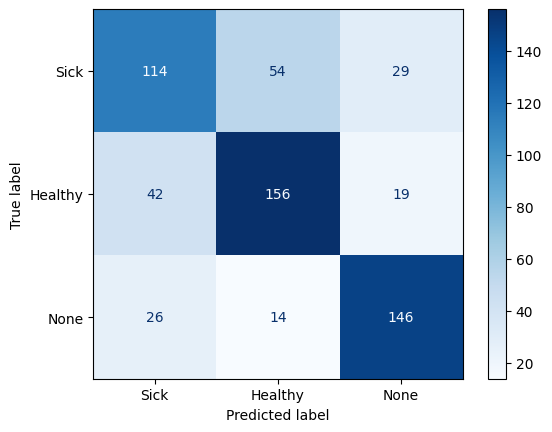

In [36]:
from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay

cm = confusion_matrix(y_test, y_pred)
disp = ConfusionMatrixDisplay(confusion_matrix=cm, 
                              display_labels=['Sick', 'Healthy', 'None'])
disp.plot(cmap='Blues')

In [ ]:
from sklearn.metrics import classification_report
class_names = ["sick", "healthy", "none"]
print(classification_report(y_test, y_pred, target_names=class_names))


              precision    recall  f1-score   support

        sick       0.81      0.81      0.81       217
     healthy       0.76      0.73      0.74       197
        none       0.85      0.90      0.87       186

    accuracy                           0.81       600
   macro avg       0.81      0.81      0.81       600
weighted avg       0.81      0.81      0.81       600

